## LePersonFinder
Description: looks for people. 
Notes: The following code is for colab specific stuff, but see the below for non-colab specific paths. 

TODOs for JChan/Teddy: 
1. Double check loss and accuracy calculations 
2. Testing loop <- finish ->
3. Model architecture 
4. Tuning 
5. Input optimization - extract boxes from actual model internals and see what it is saying = a bbox and what isn’t 5. Baseline testing (CNN, MLP, etc)

In [1]:
import os
import sys
isColab = "google.colab" in sys.modules
if isColab:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    student_colab_path = ("/content/drive/MyDrive"
        + "/Colab Notebooks")
    sys.path.append(student_colab_path)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
import numpy as np
import os
import json
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tensorflow import keras
from keras.layers import Dense, Rescaling

2024-05-05 14:11:12.017806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## COLAB SPECIFIC PATHS 
data_folder_path = "/content/drive/MyDrive/Colab Notebooks/heridal_keras_retinanet_voc"
images_path = data_folder_path + "/JPEGImages"
annotations_path = data_folder_path + "/Annotations/JSON"
ImageSets = data_folder_path + "/ImageSets/Main"

In [17]:
## GITHUB PATHS 
data_folder_path = "../data/heridal_keras_retinanet_voc"
images_path = data_folder_path + "/JPEGImages"
annotations_path = data_folder_path + "/Annotations/JSON"
ImageSets = data_folder_path + "/ImageSets/Main"

In [4]:
def xml_to_json(xml_folder, json_folder):
    os.makedirs(json_folder, exist_ok=True)

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(xml_folder, xml_file)
            json_path = os.path.join(json_folder, xml_file.replace('.xml', '.json'))

            tree = ET.parse(xml_path)
            root = tree.getroot()

            data_dict = {
                'folder': root.find('folder').text if root.find('folder') is not None else 'Unknown',
                'filename': root.find('filename').text if root.find('filename') is not None else 'Unknown',
                'size': {
                    'width': int(root.find('size/width').text) if root.find('size/width') is not None else 0,
                    'height': int(root.find('size/height').text) if root.find('size/height') is not None else 0,
                    'depth': int(root.find('size/depth').text) if root.find('size/depth') is not None else 0,
                },
                'objects': []
            }

            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                data_dict['objects'].append({
                    'name': obj.find('name').text if obj.find('name') is not None else 'Unknown',
                    'pose': obj.find('pose').text if obj.find('pose') is not None else 'Unspecified',
                    'truncated': int(obj.find('truncated').text) if obj.find('truncated') is not None else 0,
                    'difficult': int(obj.find('difficult').text) if obj.find('difficult') is not None else 0,
                    'bbox': {
                        'xmin': int(bbox.find('xmin').text) if bbox.find('xmin') is not None else 0,
                        'ymin': int(bbox.find('ymin').text) if bbox.find('ymin') is not None else 0,
                        'xmax': int(bbox.find('xmax').text) if bbox.find('xmax') is not None else 0,
                        'ymax': int(bbox.find('ymax').text) if bbox.find('ymax') is not None else 0,
                    }
                })

            with open(json_path, 'w') as json_file:
                json.dump(data_dict, json_file, indent=4)

In [5]:
#only run if json files don't exist yet
xml_folder = data_folder_path + "/Annotations"
json_folder = annotations_path
xml_to_json(xml_folder, json_folder)

In [6]:
def parse_json(json_string):
    data = json.loads(json_string.decode('utf-8'))
    if 'objects' not in data or not data['objects']:
        return np.zeros((0, 4), dtype=np.float32), np.int32(0), np.int32(data['size']['width']), np.int32(data['size']['height'])
    bounding_boxes = np.array([
        [np.int32(obj['bbox']['xmin']), np.int32(obj['bbox']['ymin']),
         np.int32(obj['bbox']['xmax']), np.int32(obj['bbox']['ymax'])]
        for obj in data['objects'] if obj['name'] == 'person'
    ], dtype=np.float32)
    num_bboxes = np.int32(len(bounding_boxes)) 
    original_width = np.int32(data['size']['width'])
    original_height = np.int32(data['size']['height'])
    return bounding_boxes, num_bboxes, original_width, original_height

def load_json(annotation_path):
    json_string = tf.io.read_file(annotation_path)
    bounding_boxes, num_bboxes, original_width, original_height = tf.numpy_function(
        parse_json, [json_string], [tf.float32, tf.int32, tf.int32, tf.int32]
    )
    bounding_boxes.set_shape([None, 4])
    num_bboxes.set_shape([])
    original_width.set_shape([])
    original_height.set_shape([])
    return bounding_boxes, num_bboxes, original_width, original_height

In [7]:
IMAGE_SIZE = 256
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
MAX_COUNT_BBOXES = 35

In [8]:
def scale_bounding_boxes(bounding_boxes, original_width, original_height, new_width, new_height, pad_w, pad_h):
  if tf.size(bounding_boxes) == 0:
    return tf.zeros((0, 4), dtype=tf.float32)

  original_width = tf.cast(original_width, tf.float32)
  original_height = tf.cast(original_height, tf.float32)
  new_width = tf.cast(new_width, tf.float32)
  new_height = tf.cast(new_height, tf.float32)
  pad_w = tf.cast(pad_w[0], tf.float32)
  pad_h = tf.cast(pad_h[0], tf.float32)

  scale_x = new_width / original_width
  scale_y = new_height / original_height

  xmin_scaled = bounding_boxes[:, 0] * scale_x + pad_w
  ymin_scaled = bounding_boxes[:, 1] * scale_y + pad_h
  xmax_scaled = bounding_boxes[:, 2] * scale_x + pad_w
  ymax_scaled = bounding_boxes[:, 3] * scale_y + pad_h

  bounding_boxes_scaled = tf.stack([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled], axis=1)

  return bounding_boxes_scaled

In [9]:
def compute_overlap_counts(bboxes, image_size, patch_size):
    num_patches_side = image_size // patch_size
    patch_indices = tf.range(0, image_size, patch_size)
    start_indices = tf.cast(tf.stack(tf.meshgrid(patch_indices, patch_indices, indexing='ij'), axis=-1), tf.float32)
    end_indices = start_indices + patch_size

    overlap_counts = tf.zeros((num_patches_side, num_patches_side), dtype=tf.int32)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        overlaps_x = tf.logical_and(start_indices[..., 1] < xmax, start_indices[..., 1] + patch_size > xmin)
        overlaps_y = tf.logical_and(start_indices[..., 0] < ymax, start_indices[..., 0] + patch_size > ymin)
        overlaps = tf.logical_and(overlaps_x, overlaps_y)

        overlap_counts += tf.cast(overlaps, tf.int32)
    
    return tf.expand_dims(overlap_counts, -1)

In [32]:
def preprocess_image(image_path, annotation_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)

  original_shape = tf.cast(tf.shape(image)[:2], tf.float32)
  ratio = IMAGE_SIZE / tf.reduce_max(original_shape)
  new_shape = tf.round(original_shape * ratio)

  image = tf.image.resize(image, tf.cast(new_shape, tf.int32))

  pad_w = (IMAGE_SIZE - new_shape[1]) / 2
  pad_h = (IMAGE_SIZE - new_shape[0]) / 2
  pad_w = [pad_w, IMAGE_SIZE - new_shape[1] - pad_w]
  pad_h = [pad_h, IMAGE_SIZE - new_shape[0] - pad_h]

  image = tf.pad(image, [[int(pad_h[0]), int(pad_h[1])], [int(pad_w[0]), int(pad_w[1])], [0, 0]], constant_values=0)
  image = Rescaling(1./255)(image)

  patches = tf.image.extract_patches(
      images=tf.expand_dims(image, 0),
      sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
      strides=[1, PATCH_SIZE, PATCH_SIZE, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'
  )
  patches = tf.reshape(patches, [-1, PATCH_SIZE * PATCH_SIZE * 3])

  bounding_boxes, num_bboxes, original_width, original_height = load_json(annotation_path)
  bounding_boxes_scaled = scale_bounding_boxes(
      bounding_boxes, original_width, original_height,
      new_shape[1], new_shape[0], pad_w, pad_h
  )

  overlap_counts = compute_overlap_counts(bounding_boxes_scaled, IMAGE_SIZE, PATCH_SIZE)
  one_hot_bboxes = tf.one_hot(num_bboxes, MAX_COUNT_BBOXES)

  return patches, overlap_counts, bounding_boxes_scaled, one_hot_bboxes

In [11]:
def file_exists(file_path):
    return tf.io.gfile.exists(file_path.numpy().decode())

def create_filtered_dataset(images_path, annotations_path, subset_prefix):
    image_files = tf.data.Dataset.list_files(os.path.join(images_path, subset_prefix + '_*.jpg'))

    def filter_func(image_file):
        annotation_file = tf.strings.regex_replace(image_file, 'JPEGImages', 'Annotations')
        annotation_file = tf.strings.regex_replace(annotation_file, '\.jpg', '.xml')
        return tf.py_function(file_exists, [annotation_file], Tout=tf.bool)

    filtered_image_dataset = image_files.filter(filter_func)

    def load_and_preprocess_image(image_file):
        annotation_file = tf.strings.regex_replace(image_file, 'JPEGImages', 'Annotations/JSON')
        annotation_file = tf.strings.regex_replace(annotation_file, '\.jpg', '.json')
        return preprocess_image(image_file, annotation_file)

    dataset = filtered_image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [33]:
train_dataset = create_filtered_dataset(images_path, annotations_path, 'train')
test_dataset = create_filtered_dataset(images_path, annotations_path, 'test')

for patches, overlap_counts, bboxes, one_hot_bboxes in train_dataset:
    # print('Train patches shape:', patches.shape)
    print('Train patches', patches)
    # print('Train bounding boxes:', bboxes)
    # print('Train overlap counts shape:', overlap_counts.shape)
    # print('Train sample overlap counts:', overlap_counts.numpy().flatten()[:256])
    # print('Train one-hot encoded bounding boxes:', one_hot_bboxes.numpy())

# for patches, overlap_counts, bboxes, one_hot_bboxes in test_dataset:
#     print('Test patches shape:', patches.shape)
#     print('Test bounding boxes:', bboxes)
#     print('Test overlap counts shape:', overlap_counts.shape)
#     print('Test sample overlap counts:', overlap_counts.numpy().flatten()[:256])
#     print('Test one-hot encoded bounding boxes:', one_hot_bboxes.numpy())

Tensor("resize/Squeeze:0", shape=(None, None, 3), dtype=float32)
Tensor("resize/Squeeze:0", shape=(None, None, 3), dtype=float32)


2024-05-05 14:23:54.598150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]
2024-05-05 14:23:54.598360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]


Train patches tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 768), dtype=float32)
Train patches tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 768), dtype=float32)
Train patches tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 768), dtype=float32)
Train patches tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 768), dtype=float32)
Train patches tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0.

KeyboardInterrupt: 

2024-05-05 14:22:41.883380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]
2024-05-05 14:22:41.883645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(256, 256, 3), dtype=float32)


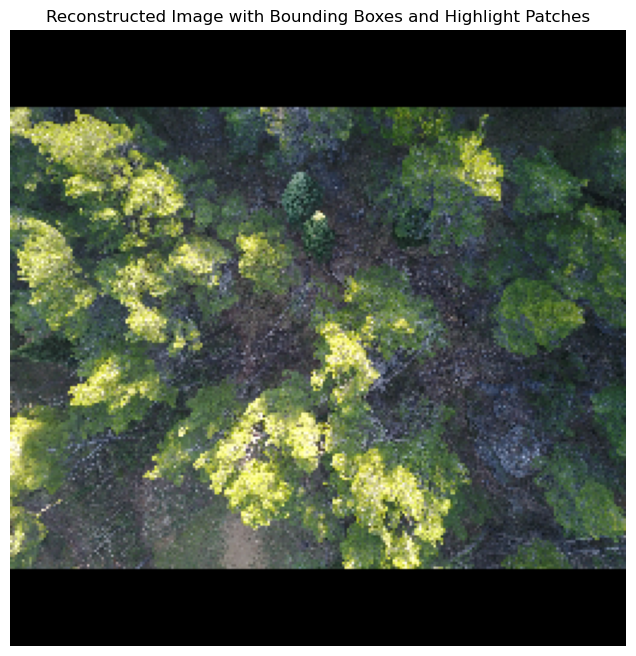

In [31]:
def display_image_with_bboxes(image_patches, overlap_counts, bbox_data, num_patches_side):
    patches_reshaped = tf.reshape(image_patches, [num_patches_side, num_patches_side, PATCH_SIZE, PATCH_SIZE, 3])
    patches_transposed = tf.transpose(patches_reshaped, [0, 2, 1, 3, 4])
    image_reconstructed = tf.reshape(patches_transposed, [IMAGE_SIZE, IMAGE_SIZE, 3])

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image_reconstructed)

    for bbox in bbox_data:
        y_min = bbox[1]
        x_min = bbox[0]
        y_max = bbox[3]
        x_max = bbox[2]
        print(f"Bounding Box: [{x_min}, {y_min}, {x_max}, {y_max}]")

        width = x_max - x_min
        height = y_max - y_min

        rect = mpatches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    for i in range(num_patches_side):
        for j in range(num_patches_side):
            if overlap_counts[i, j, 0] > 0:
                patch_x = j * PATCH_SIZE
                patch_y = i * PATCH_SIZE
                rect = mpatches.Rectangle((patch_x, patch_y), PATCH_SIZE, PATCH_SIZE, linewidth=1, edgecolor='yellow', facecolor='none', linestyle='--')
                ax.add_patch(rect)
                ax.text(patch_x + PATCH_SIZE / 2, patch_y + PATCH_SIZE / 2, str(overlap_counts[i, j, 0]),
                        color='yellow', ha='center', va='center', fontsize=8)

    plt.title("Reconstructed Image with Bounding Boxes and Highlight Patches")
    plt.axis('off')
    plt.show()

for image_patches, overlap_counts, bbox_data, one_hot_bboxes in train_dataset.take(1):
    num_patches_side = IMAGE_SIZE // PATCH_SIZE
    display_image_with_bboxes(image_patches.numpy(), overlap_counts.numpy(), bbox_data.numpy(), num_patches_side)

## Model Class
The following code is for the Model class of the Transformer model. 

Some key notes about our dataset: 
- 7 classes 
- (256, 768) inputs

Some key notes about other parameters: 
- Query: of shape (batch_sz, target_seq_length, feature_dim)
- Value: of shape (batch_sz, source_seq_length, feature_dim)
- Key: of shape (batch_sz, source_seq_length, feature_dim)

Our architecture using the below classes goes as follows: 


### Hyperparameters/Stats
Hyperparameters and stats for our model pre-compilation.

In [117]:
## Hyperparameters & general stats
params = {
    'batch_sz': 64, 
    'num_classes': 35,
    'vocab_sz': 35,  
    'num_att_heads': 1, 
    'key_dim': 10, 
    'query_dim': 10, 
    'value_dim': 10, 
    'output_sz': 8, 
    'window_sz': 256,
    'num_features': 768, 
    'emb_sz': 132, 
    'num_layers': 2, 
    'learning_rate': 0.01, 
    'num_epochs': 20, 
}

Don't run this next cell :)

In [ ]:
## TODO: This takes like way too long to run - could anyone create tensors that have a batch dimension?

all_cts = set()
all_cts.add(0)
img_patches_shape = set()
overlap_cts_shape = set()
bbox_data_shape = set() 
len_train = 0

train_img_patches = tf.Variable(tf.random.normal((1546, 256, 768), dtype=tf.float32))
train_overlap_counts = tf.Variable(tf.zeros((1546, 16, 16, 1), dtype=tf.int32))

for image_patches, overlap_counts, bbox_data in train_dataset:
    len_train += 1  
    img_patches_shape.add(image_patches.shape)
    overlap_cts_shape.add(overlap_counts.shape)
    bbox_data_shape.add(bbox_data.shape) ## Bbox shape is NOT uniform unfortunately 
    all_cts.add(bbox_data.shape[0])

print("This is the size of the train dataset: ", len_train)
print("These are the img patches shape: ", img_patches_shape)
print("These are overlap cts shape: ", overlap_cts_shape)
print("These are bbox shape: ", bbox_data_shape)

len_test = 0
test_img_patches = tf.Variable(tf.random.normal((101, 256, 768), dtype=tf.float32))
test_overlap_counts = tf.Variable(tf.zeros((101, 16, 16, 1), dtype=tf.int32))
for test_image_patches, test_overlap_counts, test_bbox_data in test_dataset:
    all_cts.add(test_bbox_data.shape[0])
    len_test += 1

print("This is the size of the test dataset: ", len_test)
print("This is the total number of classes: ", all_cts)

### Positional Encoding 
This defines our positional encoding class. This will positionally encode our input tensor so that the Transformer has some understanding of how the pixels are distributed spatially. 

In [118]:
## Taken from class - positional encoding method. 
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 
  return tf.cast(pos_encoding, dtype=tf.float32)

## Taken from class - positional embedding class that will look a token's embedding vector and add the corresponding position vector 
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, emb_sz):
    super().__init__()
    self.emb_sz = emb_sz
    self.embedding = tf.keras.layers.Dense(emb_sz)
    self.pos_encoding = positional_encoding(length=2048, depth=emb_sz)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.emb_sz, tf.float32)) # This factor sets the relative scale of the embedding and positonal_encoding.
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x
  
## UNIT TEST: check sizes @ embedding 
test_emb = tf.zeros((params['batch_sz'], params['window_sz'], params['num_features']))
embed_img = PositionalEmbedding(vocab_size=params['vocab_sz'], emb_sz=params['emb_sz'])
embed = embed_img(test_emb)
print("This is the positional embedding shape: ", embed.shape)


This is the positional embedding shape:  (64, 256, 132)


### Attention
- BaseAttention: super class that other variations of Attention can inherit from. Essentially combines Attention + LayerNormalization into one class.
- Other subclasses...

In [119]:
## Base Attention Class
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## This class is just a basic implementation of self-attention 
class GlobalSelfAttention(BaseAttention): 
    def call(self, x): 
      attn_output, attn_scores = self.mha(query=x, key=x, value=x, return_attention_scores=True)
      # Cache the attention scores for plotting later.
      self.last_attn_scores = attn_scores 
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
    
## This class is just the masked implementation of self-attention
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## This class connects the Encoder and Decoder: takes in context sequence for keys and values as opposed to the input sequence.  
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # Multi-headed attention 
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
  
sample_sa = GlobalSelfAttention(num_heads=params['num_att_heads'], key_dim=params['key_dim'])
att_on_emb = sample_sa(embed)
print("This is the shape post-self attention: ", att_on_emb.shape)

This is the shape post-self attention:  (64, 256, 132)


### FeedForward Layers
- This class defines feedforward layers that produce our desired output after we apply attention to our input. This combines ADD + LayerNormalization in as well. 


In [120]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, emb_sz, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(emb_sz),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)]) # Residual connection 
    x = self.layer_norm(x) # Layer norm
    return x

### Encoder Block
There are two classes in this section: 
- Encoder Layer: one unit of the block. Attention -> LayerNorm -> FeedForward NN. 
- Encoder Block: we can have many stacked Encoder layers. All this does is create a positional embedding for the input, add it to the input, then pass that into a stack of Encoder layers. 

In [121]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, emb_sz, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = BaseAttention(
        num_heads=num_heads,
        key_dim=emb_sz,
        dropout=dropout_rate)
    self.ffn = FeedForward(emb_sz, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [122]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, emb_sz, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.emb_sz = emb_sz
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, emb_sz=emb_sz)
    self.enc_layers = [
        EncoderLayer(emb_sz=emb_sz,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Should result in shape of (batch_size, seq_len, emb_sz).
    x = self.dropout(x)  # Add dropout.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Should result in shape of (batch_size, seq_len, emb_sz).

### Decoder Block 
There are two classes in this section: 
- Decoder Block: one unit of the block. Self attention -> Cross attention -> Feed forward network. 
- Decoder: stacked Decoder layers.

In [123]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, emb_sz, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=emb_sz, dropout=dropout_rate) # Masked self attention 
    self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=emb_sz, dropout=dropout_rate)  # Encoder-decoder attention 
    self.ffn = FeedForward(emb_sz, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, emb_sz)`.
    return x

In [124]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, emb_sz, num_heads, dff, vocab_size,
               dropout_rate=0.1, all_patches):
    super(Decoder, self).__init__()
    self.emb_sz = emb_sz
    self.num_layers = num_layers
    self.all_patches = all_patches
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, emb_sz=emb_sz)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(emb_sz=emb_sz, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
    self.ffout = tf.keras.layers.Dense(1)
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, emb_sz)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    if self.all_patches: 
      x = tf.transpose(x, perm=[0, 2, 1])
      x = self.ffout(x)

    return x # The shape of x is (batch_size, target_seq_len, emb_sz) (ideally) - if not (batch_size, 1, emb_sz)

### Transformer Model
This combines our Encoder and Decoder blocks into a coherent model. It should look something like the following: 
- Positional Encoding + Addition of Context => 
- => Encoder Block: 
    - Encoder Layer 1: 
        - Self Attention 
        - Feed Forward NN 
            - Dense 1 
            - Dense 2 
            - Dropout 
            - Add & LayerNormalization
    - Encoder Layer 2: 
        - Self Attention 
        - Feed Forward NN 
            - Dense 1 
            - Dense 2 
            - Dropout 
            - Add & LayerNormalization 
    - etc ...
- => Decoder Block: 
    - Decoder Layer 1: 
        - Causal Self Attention 
        - Cross Attention 
        - Feed Forward NN 
            - Dense 1
            - Dense 2 
            - Dropout 
            - Add & LayerNormalization
    - etc ...

In [165]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, emb_sz, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.emb_context = tf.keras.layers.Dense(emb_sz)
    self.emb_patches = tf.keras.layers.Dense(emb_sz)
    
    self.encoder = Encoder(num_layers=num_layers, emb_sz=emb_sz,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, emb_sz=emb_sz,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate,
                           all_patches=True)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  # COMPILE 
  def compile(self, optimizer, loss, metrics):
    self.optimizer = optimizer
    self.loss_function = loss 
    self.accuracy_function = metrics[0]

  # FORWARD PASS
  def call(self, inputs):
    patches, bbox_context = inputs  

    # flatten & upsample the context, input: the following should return (batch_sz, 256, emb_sz)
    bbox_context = tf.reshape(bbox_context, (bbox_context.shape[0], -1, 1))
    bbox_context = self.emb_context(bbox_context)
    patches = self.emb_patches(patches)
    embedded = bbox_context + patches
    # The following should return: (batch_sz, 256, emb_sz): (batch_size, context_len, emb_sz)
    context = self.encoder(embedded)
    # The following should return: (batch_size, 256, emb_sz): (batch_size, target_len, emb_sz)
    x = self.decoder(patches, context)
    # The following should return: (batch_size, 256, 8): (batch_size, target_len, target_vocab_size)
    logits = tf.squeeze(x, axis=2) 
    logits = self.final_layer(logits)
    smax = tf.nn.softmax(logits) # TODO: softmax over the last dimension 

    # nk - idrk what this following section does...
    try:
      del logits._keras_mask  # Drop the keras mask, so it doesn't scale the losses/metrics. b/250038731
    except AttributeError:
      pass
    return smax # Return the final output and the attention weights.
  
  ## TRAIN STEP (per epoch)
  def train(self, train_dataset, params, train_metrics_dict): 
      train_loss_per_epoch, train_accuracy_per_epoch = 0, 0
      train_dataset.shuffle(buffer_size=3) # Shuffle the dataset every epoch
      num_batches = 0
      for patches, bbox_context, labels in train_dataset:
          with tf.GradientTape() as tape: 
            out = self((patches, bbox_context))
            loss = self.loss_function(labels, out)
            accuracy = self.accuracy_function(labels, out) 
            train_loss_per_epoch+=loss.numpy()
            train_accuracy_per_epoch+=accuracy.numpy()
            num_batches += 1
          grads = tape.gradient(loss, self.trainable_variables) # Compute the gradients 
          self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
      train_loss_per_epoch = train_loss_per_epoch / num_batches
      train_accuracy_per_epoch = train_accuracy_per_epoch / num_batches
      train_metrics_dict['Loss'].append(train_loss_per_epoch)
      train_metrics_dict['Accuracy'].append(train_accuracy_per_epoch)

  def test(): 
     pass 

### Accuracy and Loss Metrics
Title. 

In [127]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction='none')
  loss = loss_object(label, pred)
  # TODO: understand masked loss/implement if necessary
  # print(loss)
  # mask = tf.cast(mask, dtype=loss.dtype)
  # loss *= mask
  # loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return tf.reduce_sum(loss)/(label.shape[0])

def masked_accuracy(label, pred):
    # Compute the index of the maximum prediction. This represents the predicted class.
    pred_indices = tf.argmax(pred, axis=1)
    # Similarly, find the index of the true class from the one-hot encoded labels.
    true_indices = tf.argmax(label, axis=1)
    # Compare predicted indices with true indices to see where they match.
    correct_predictions = tf.equal(pred_indices, true_indices)
    # Calculate the accuracy as the mean of the correct predictions
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy


### Train and Fit the Model
Some notable modifications I had to make: 
1. For purposes of actually being able to do multi-class classifications, had to manually OHE the labels during the training loop (not ideal, but it works). 
2. Had to zip two separate datasets. Again not ideal but it's the only way I could batch the data without going insane/doing manually and also getting the labels because otherwise the tuple returned from each iteration of the dataset would not have uniform shapes, so I couldn't use built-ins. 


Labels: 
at each iteration: 
    iamge_patches, overlap_cts, bbox 
        - none are batched
        - either: 
            - manually batch 
            - iamge_patches, overlap_cts << new dataset >> 
    [13,4] -> 13 bboxes 
    [batch_sz, number_of_patches, number_of_classes]
    [64, 256, 35] <- [64, 35] OR [64, 1, 35] -> [64, 35]
        - [64, 35, 256] -> [64, 35, 1] -> [64, 35]
    [64, 35] 
    number_of_classes <- 35 total bboxes for each image, max 




In [166]:
## Instantiations of above objects
transformer = Transformer(num_layers=params['num_layers'], 
                          emb_sz=params['emb_sz'],
                          num_heads=params['num_att_heads'], 
                          dff=params['num_features'], 
                          input_vocab_size=params['vocab_sz'],
                          target_vocab_size=params['vocab_sz'])
optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])

## Compile the model 
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

## First create batched training/testing data 
def reconstruct_datasets(train_dataset, test_dataset): 
    '''
    This is a method that reconstructs/batches our datasets.
    '''
    def remove_non_uniform_bbox(c1, c2, c3, c4): 
        return c1, c2, c4
    batchable_train_data = train_dataset.map(remove_non_uniform_bbox)
    batched_train_dataset = batchable_train_data.batch(batch_size=params['batch_sz'], drop_remainder=False)
    batchable_test_data = test_dataset.map(remove_non_uniform_bbox)
    batched_test_dataset = batchable_test_data.batch(batch_size=params['batch_sz'], drop_remainder=False)
    return batched_train_dataset, batched_test_dataset
 
 
def train(params, batched_train_dataset, train_metrics_dict): 
    '''
    This is a method that calls on our model's custom train method. 
    '''
    training_start = time.time()
    for e in range(params['num_epochs']): 
        transformer.train(batched_train_dataset, params, train_metrics_dict)
        epoch_loss, epoch_acc = train_metrics_dict['Loss'][e], train_metrics_dict['Accuracy'][e]
        print(f'Epoch: {e} | Loss: {epoch_loss} | Accuracy: {epoch_acc}')
    training_end = time.time()
    print(f'Training took: {(training_end-training_start) // 60} minutes')
        
batched_train_dataset, batched_test_dataset = reconstruct_datasets(train_dataset, test_dataset)
train_metrics_dict={'Loss':[], 'Accuracy':[]}
train(params, batched_train_dataset, train_metrics_dict)


2024-04-26 14:30:05.988241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]
2024-04-26 14:30:05.988562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]


Epoch: 0 | Loss: 3.6262741231918336 | Accuracy: 0.25400000005960466
Epoch: 1 | Loss: 1.7974481534957887 | Accuracy: 0.3546250000596046
Epoch: 2 | Loss: 1.7837471818923951 | Accuracy: 0.3613750004768372
Epoch: 3 | Loss: 1.8063743925094604 | Accuracy: 0.3647500002384186
Epoch: 4 | Loss: 1.8156927633285522 | Accuracy: 0.31512500047683717
Epoch: 5 | Loss: 1.8041430616378784 | Accuracy: 0.3647500002384186
Epoch: 6 | Loss: 1.7788229608535766 | Accuracy: 0.30337500005960466
Epoch: 7 | Loss: 1.7447764015197753 | Accuracy: 0.33462500005960466
Epoch: 8 | Loss: 1.7438497257232666 | Accuracy: 0.3285000002384186
Epoch: 9 | Loss: 1.80813889503479 | Accuracy: 0.3647500002384186
Epoch: 10 | Loss: 1.8088928270339966 | Accuracy: 0.3367500001192093
Epoch: 11 | Loss: 1.8011519813537598 | Accuracy: 0.32450000047683714
Epoch: 12 | Loss: 1.7841866111755371 | Accuracy: 0.34112500011920927
Epoch: 13 | Loss: 1.7773220443725586 | Accuracy: 0.366875
Epoch: 14 | Loss: 1.7561441802978515 | Accuracy: 0.36375
Epoch: 

In [84]:
# Unit testing dataset
for el1, el2, el3, el4 in train_dataset.take(1): 
    print(el1.shape, el2.shape, el3.shape, el4.shape)

2024-04-26 13:27:20.555207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]
2024-04-26 13:27:20.555433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1583]
	 [[{{node Placeholder/_0}}]]
2024-04-26 13:27:20.652981: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 1-th value returned by pyfunc_13 is int64, but expects int32
	 [

(256, 768) (16, 16, 1) (4, 4) (35,)


2024-04-26 13:27:20.858119: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: 1-th value returned by pyfunc_13 is int64, but expects int32
	 [[{{node PyFunc}}]]
